In [1]:
# Import Packages
from softcomputing_packages_bu import *

Importing Soft Computing Packages . . .
Copyright 2019, Seok-Jun Bu, Softcomputing Lab. All Rights Reserved.
. . . Done.


In [2]:
# Load Dataset
df = pd.read_csv('df_grouped_rate.csv')
df.tail()

,year,district,code,sales_total,s_store_no_of_store,s_store_no_of_opening,s_store_no_of_closing,s_work_female,s_float_male,s_float_female,...,b_apt_avg_price,b_income_avg_monthly_inc,sales_weekday,sales_female,sales_2030s,sales_06_11,sales_11_14,sales_14_17,sales_17_21,sales_21_24
113260,2019,1001010,CS300008,1.441360e+08,2.0,0,0,230,164052,179007,...,154040746.0,3256684.0,0.881982,0.513650,0.083578,0.108358,0.346493,0.395632,0.149517,0.0
113261,2019,1001010,CS300009,3.067237e+09,2.0,0,0,230,164052,179007,...,154040746.0,3256684.0,0.931167,0.474928,0.128200,0.262188,0.297561,0.325539,0.114712,0.0
113262,2019,1001010,CS300011,1.794132e+07,1.0,0,1,230,164052,179007,...,154040746.0,3256684.0,0.640979,0.320036,0.046238,0.006346,0.508613,0.275612,0.209429,0.0
113263,2019,1001010,CS300016,8.942270e+06,3.0,0,0,230,164052,179007,...,154040746.0,3256684.0,0.624137,0.374046,0.322065,0.225009,0.288986,0.227190,0.258815,0.0
113264,2019,1001010,CS300017,3.687740e+06,6.0,0,0,230,164052,179007,...,154040746.0,3256684.0,0.976623,0.800000,0.371429,0.000000,0.129870,0.166234,0.703896,0.0


In [3]:
# X, Y Definition
X, Y = df.drop(['sales_total'], axis=1), df.sales_total.values
print(X.shape, Y.shape)

(113265, 20) (113265,)


In [4]:
# Preprocessing X: One-hot Encoding
X_district = df.district
X_district_cat = pd.get_dummies(X_district)
X = pd.concat([X_district_cat, pd.get_dummies(X.drop('district', axis=1))], axis=1)
print(X.shape, Y.shape)

(113265, 1070) (113265,)


In [5]:
# Preprocessing X: Robust Scaling
rb = RobustScaler()
X = rb.fit_transform(X)

In [9]:
# Preprocessing Y: Min-max Scaling (for Feasibility Test)
Y_max, Y_min = np.max(Y), np.min(Y)
Y_norm = Y-Y_min
Y_norm /= (Y_max-Y_min)

In [10]:
# Train, Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_norm, test_size=0.2, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(90612, 1070) (90612,)
(22653, 1070) (22653,)


In [39]:
# Build CNN Model
c_input = Input(shape=X_train.shape[1]) 
H = Reshape((X_train.shape[1], 1))(c_input)
H = Conv1D(filters=16, kernel_size=(2), activation='tanh')(H)
H = MaxPool1D(2)(H)
H = Dropout(0.5)(H)
H = Conv1D(filters=16, kernel_size=(2), activation='tanh')(H)
H = MaxPool1D(2)(H)
H = Dropout(0.5)(H)
H = Conv1D(filters=16, kernel_size=(2), activation='tanh')(H)
H = MaxPool1D(2)(H)
H = Dropout(0.5)(H)
H = Conv1D(filters=16, kernel_size=(2), activation='tanh')(H)
H = MaxPool1D(2)(H)
H = Dropout(0.5)(H)
H = Flatten()(H)
H = Dense(512, activation='tanh')(H)
H = Dense(256, activation='tanh')(H)
c_output = Dense(1, activation='sigmoid')(H)
model_cnn = Model(c_input, c_output)
model_cnn.summary()
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse', 'kullback_leibler_divergence'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1070)]            0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1070, 1)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1069, 16)          48        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 534, 16)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 534, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 533, 16)           528       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 266, 16)           0   

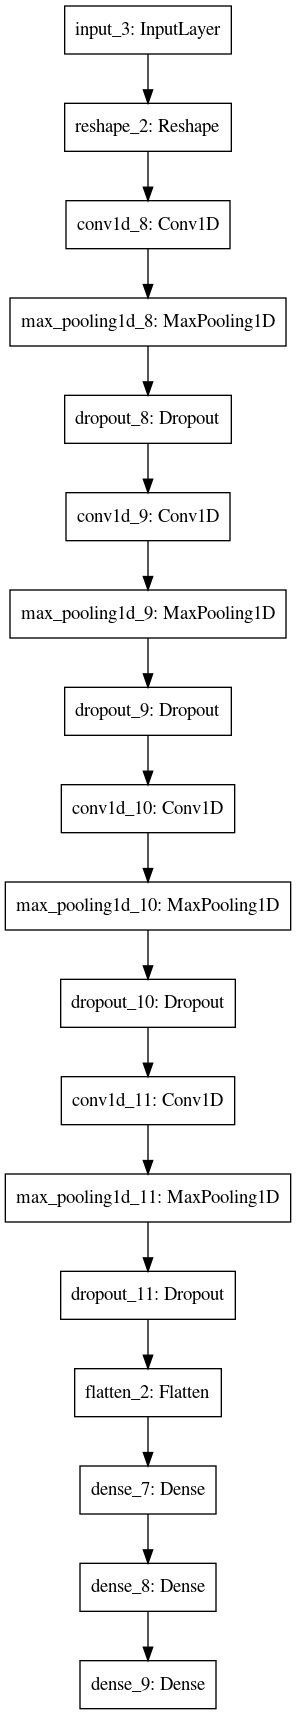

In [40]:
# Visualize Model
plot_model(model_cnn)

In [41]:
# Train, Validate Model
es = EarlyStopping(monitor='val_loss', patience=50, mode='min', restore_best_weights=True)
model_cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=4096, epochs=1000, verbose=2, shuffle=True, callbacks=[es])

Train on 90612 samples, validate on 22653 samples
Epoch 1/1000
90612/90612 - 5s - loss: 0.1477 - mse: 0.0177 - kullback_leibler_divergence: 0.0357 - val_loss: 0.0732 - val_mse: 8.9228e-04 - val_kullback_leibler_divergence: 0.0108
Epoch 2/1000
90612/90612 - 2s - loss: 0.0780 - mse: 0.0010 - kullback_leibler_divergence: 0.0221 - val_loss: 0.0860 - val_mse: 0.0019 - val_kullback_leibler_divergence: -2.2407e-03
Epoch 3/1000
90612/90612 - 2s - loss: 0.0720 - mse: 8.4875e-04 - kullback_leibler_divergence: 0.0144 - val_loss: 0.0839 - val_mse: 0.0016 - val_kullback_leibler_divergence: -2.4731e-03
Epoch 4/1000
90612/90612 - 2s - loss: 0.0704 - mse: 7.9852e-04 - kullback_leibler_divergence: 0.0135 - val_loss: 0.0774 - val_mse: 0.0011 - val_kullback_leibler_divergence: 4.6055e-04
Epoch 5/1000
90612/90612 - 2s - loss: 0.0701 - mse: 7.9109e-04 - kullback_leibler_divergence: 0.0131 - val_loss: 0.0757 - val_mse: 0.0010 - val_kullback_leibler_divergence: 0.0013
Epoch 6/1000
90612/90612 - 2s - loss: 0.

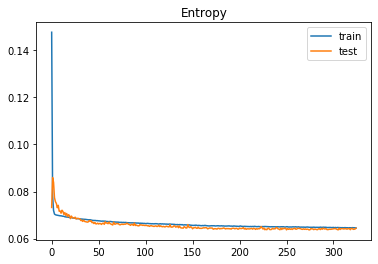

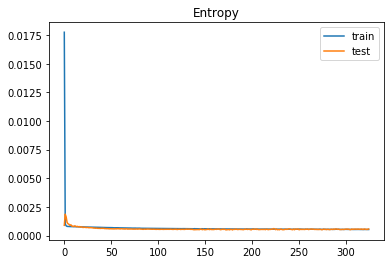

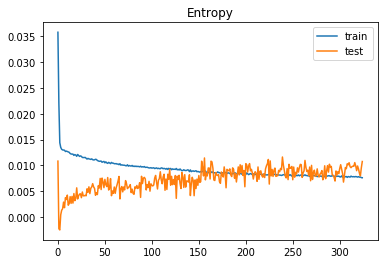

In [43]:
# Plot Learning Curve
plot_history(model_input=model_cnn, mode='loss')
plot_history(model_input=model_cnn, mode='mse')
plot_history(model_input=model_cnn, mode='kullback_leibler_divergence')

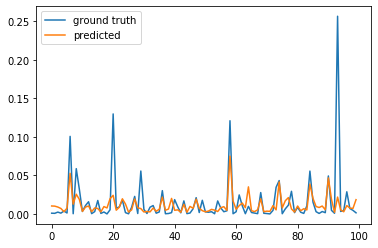

In [69]:
# Validate: Visualize Test
sample_range = 100
idx_start = np.random.randint(0, X_test.shape[0])
ground_truth = Y_test[idx_start:idx_start+sample_range]
predicted = model_cnn.predict(X_test[idx_start:idx_start+sample_range])
plt.plot(ground_truth)
plt.plot(predicted)
plt.legend(['ground truth', 'predicted'])
plt.show()

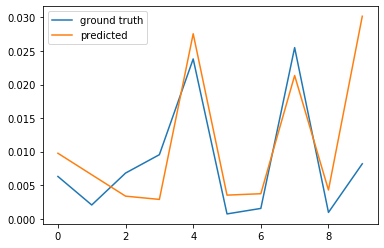

In [76]:
# Validate: Visualize Test
sample_range = 10
idx_start = np.random.randint(0, X_test.shape[0])
ground_truth = Y_test[idx_start:idx_start+sample_range]
predicted = model_cnn.predict(X_test[idx_start:idx_start+sample_range])
plt.plot(ground_truth)
plt.plot(predicted)
plt.legend(['ground truth', 'predicted'])
plt.show()